In [1]:
import fastbook
fastbook.setup_book()

In [2]:
from fastai.vision.all import *

In [3]:
train = pd.read_csv(Path("./train.csv"))
print('Train data shape:', train.shape)

Train data shape: (42000, 785)


In [4]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,pixel41,pixel42,pixel43,pixel44,pixel45,pixel46,pixel47,pixel48,pixel49,pixel50,pixel51,pixel52,pixel53,pixel54,pixel55,pixel56,pixel57,pixel58,pixel59,pixel60,pixel61,pixel62,pixel63,pixel64,pixel65,pixel66,pixel67,pixel68,pixel69,pixel70,pixel71,pixel72,pixel73,pixel74,pixel75,pixel76,pixel77,pixel78,pixel79,pixel80,pixel81,pixel82,pixel83,pixel84,pixel85,pixel86,pixel87,pixel88,pixel89,pixel90,pixel91,pixel92,pixel93,pixel94,pixel95,pixel96,pixel97,pixel98,pixel99,pixel100,pixel101,pixel102,pixel103,pixel104,pixel105,pixel106,pixel107,pixel108,pixel109,pixel110,pixel111,pixel112,pixel113,pixel114,pixel115,pixel116,pixel117,pixel118,pixel119,pixel120,pixel121,pixel122,pixel123,pixel124,pixel125,pixel126,pixel127,pixel128,pixel129,pixel130,pixel131,pixel132,pixel133,pixel134,pixel135,pixel136,pixel137,pixel138,pixel139,pixel140,pixel141,pixel142,pixel143,pixel144,pixel145,pixel146,pixel147,pixel148,pixel149,pixel150,pixel151,pixel152,pixel153,pixel154,pixel155,pixel156,pixel157,pixel158,pixel159,pixel160,pixel161,pixel162,pixel163,pixel164,pixel165,pixel166,pixel167,pixel168,pixel169,pixel170,pixel171,pixel172,pixel173,pixel174,pixel175,pixel176,pixel177,pixel178,pixel179,pixel180,pixel181,pixel182,pixel183,pixel184,pixel185,pixel186,pixel187,pixel188,pixel189,pixel190,pixel191,pixel192,pixel193,pixel194,pixel195,pixel196,pixel197,pixel198,pixel199,pixel200,pixel201,pixel202,pixel203,pixel204,pixel205,pixel206,pixel207,pixel208,pixel209,pixel210,pixel211,pixel212,pixel213,pixel214,pixel215,pixel216,pixel217,pixel218,pixel219,pixel220,pixel221,pixel222,pixel223,pixel224,pixel225,pixel226,pixel227,pixel228,pixel229,pixel230,pixel231,pixel232,pixel233,pixel234,pixel235,pixel236,pixel237,pixel238,pixel239,pixel240,pixel241,pixel242,pixel243,pixel244,pixel245,pixel246,pixel247,pixel248,pixel249,pixel250,pixel251,pixel252,pixel253,pixel254,pixel255,pixel256,pixel257,pixel258,pixel259,pixel260,pixel261,pixel262,pixel263,pixel264,pixel265,pixel266,pixel267,pixel268,pixel269,pixel270,pixel271,pixel272,pixel273,pixel274,pixel275,pixel276,pixel277,pixel278,pixel279,pixel280,pixel281,pixel282,pixel283,pixel284,pixel285,pixel286,pixel287,pixel288,pixel289,pixel290,pixel291,pixel292,pixel293,pixel294,pixel295,pixel296,pixel297,pixel298,pixel299,pixel300,pixel301,pixel302,pixel303,pixel304,pixel305,pixel306,pixel307,pixel308,pixel309,pixel310,pixel311,pixel312,pixel313,pixel314,pixel315,pixel316,pixel317,pixel318,pixel319,pixel320,pixel321,pixel322,pixel323,pixel324,pixel325,pixel326,pixel327,pixel328,pixel329,pixel330,pixel331,pixel332,pixel333,pixel334,pixel335,pixel336,pixel337,pixel338,pixel339,pixel340,pixel341,pixel342,pixel343,pixel344,pixel345,pixel346,pixel347,pixel348,pixel349,pixel350,pixel351,pixel352,pixel353,pixel354,pixel355,pixel356,pixel357,pixel358,pixel359,pixel360,pixel361,pixel362,pixel363,pixel364,pixel365,pixel366,pixel367,pixel368,pixel369,pixel370,pixel371,pixel372,pixel373,pixel374,pixel375,pixel376,pixel377,pixel378,pixel379,pixel380,pixel381,pixel382,pixel383,pixel384,pixel385,pixel386,pixel387,pixel388,pixel389,pixel390,pixel391,pixel392,pixel393,pixel394,pixel395,pixel396,pixel397,pixel398,pixel399,pixel400,pixel401,pixel402,pixel403,pixel404,pixel405,pixel406,pixel407,pixel408,pixel409,pixel410,pixel411,pixel412,pixel413,pixel414,pixel415,pixel416,pixel417,pixel418,pixel419,pixel420,pixel421,pixel422,pixel423,pixel424,pixel425,pixel426,pixel427,pixel428,pixel429,pixel430,pixel431,pixel432,pixel433,pixel434,pixel435,pixel436,pixel437,pixel438,pixel439,pixel440,pixel441,pixel442,pixel443,pixel444,pixel445,pixel446,pixel447,pixel448,pixel449,pixel450,pixel451,pixel452,pixel453,pixel454,pixel455

In [5]:
# Display settings
plt.rcParams['figure.figsize'] = 12, 8
plt.rcParams.update({'font.size': 11})
plt.style.use('fivethirtyeight')

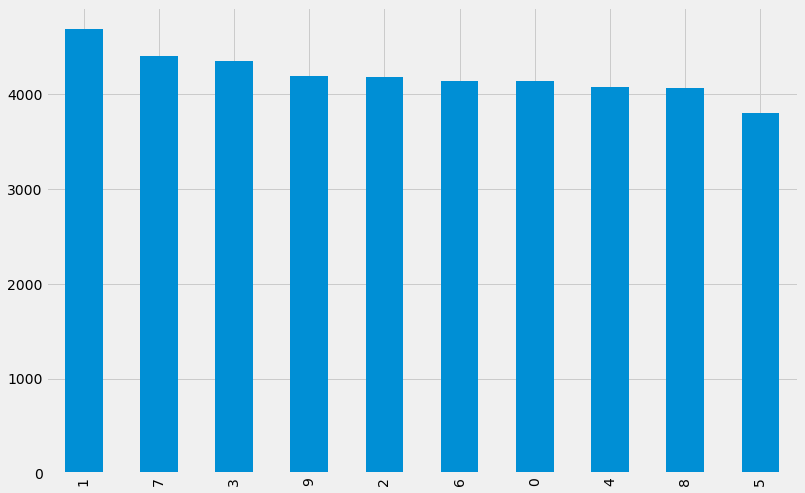

In [6]:
train['label'].value_counts().plot.bar()
plt.show()

## Display Images

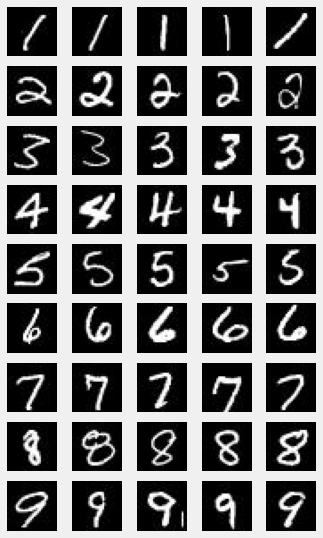

In [7]:
def displayRandomImagesFromEveryFolder(directory=Path("./train"), samplesPerDigit=5):

    fig = plt.figure(figsize=(5,10))
    
    for rowIndex in range(1, 10):
        subdirectory = str(rowIndex)
        path = directory/subdirectory
        images = os.listdir(path)
        for sampleIndex in range(1,samplesPerDigit+1):
            randomNumber = random.randint(0, len(images)-1)
            image = Image.open(path/images[randomNumber])
            ax = fig.add_subplot(10, 5, samplesPerDigit*rowIndex + sampleIndex)
            ax.axis("off")
            
            plt.imshow(image, cmap='gray')
            
    
    plt.show()
    
displayRandomImagesFromEveryFolder()

## Prepare Data

In [8]:
from torchvision import transforms

class NumberDataset:
    def __init__(self, data, transform=None):
        self.data = data.reset_index(drop=True)
        self.trans = transform
    
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, index):
        
        d = self.data.iloc[index, 1:].values.reshape(1, 28, 28)
        
        if self.trans:
            d = self.trans(tensor(d))
        else:
            d = tensor(d)/255
        
        y = self.data.iloc[index, 0]
        
        return d, tensor(y)

In [9]:
train_idx, valid_idx = RandomSplitter()(train)

device = "cuda" if torch.cuda.is_available() else "cpu"

train_ds = NumberDataset(train.iloc[train_idx, :])
valid_ds = NumberDataset(train.iloc[valid_idx, :])

train_dl = DataLoader(train_ds, bs=64)
valid_dl = DataLoader(valid_ds, bs=128)

dls = DataLoaders(train_dl, valid_dl).to(device)

In [10]:
model = nn.Sequential(
    ConvLayer(1, 32),
    ConvLayer(32, 64),
    nn.MaxPool2d(2),
    ConvLayer(64, 128),
    ConvLayer(128, 256),
    nn.MaxPool2d(2),
    ConvLayer(256, 512),
    ConvLayer(512, 1024),
    nn.MaxPool2d(2),
    nn.AdaptiveAvgPool2d(1),
    Flatten(), 
    nn.Linear(1024, 256),
    nn.Dropout(0.5),
    nn.Linear(256, 10)
).to(device)

In [11]:
learn = Learner(dls, model, metrics=accuracy, 
                loss_func=LabelSmoothingCrossEntropy())

/home/ubuntu/miniconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


SuggestedLRs(valley=0.00010964782268274575)

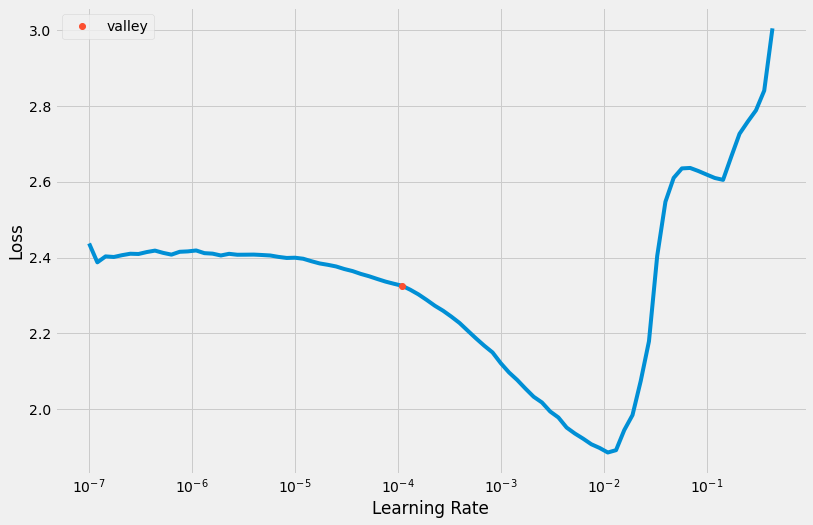

In [12]:
learn.lr_find()

In [13]:
learn.fit_one_cycle(15, 1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,1.064205,0.882112,0.927381,00:29
1,0.632339,0.609939,0.981191,00:29
2,0.586332,0.596612,0.985000,00:29
3,0.564324,0.587415,0.988929,00:29
4,0.549415,0.568139,0.992024,00:30
5,0.537785,0.556911,0.994048,00:30
6,0.530447,0.541296,0.995238,00:30
7,0.524916,0.549530,0.994405,00:30
8,0.521783,0.537644,0.995714,00:30
9,0.518815,0.539355,0.993810,00:30


In [14]:
preds, targs = learn.get_preds()

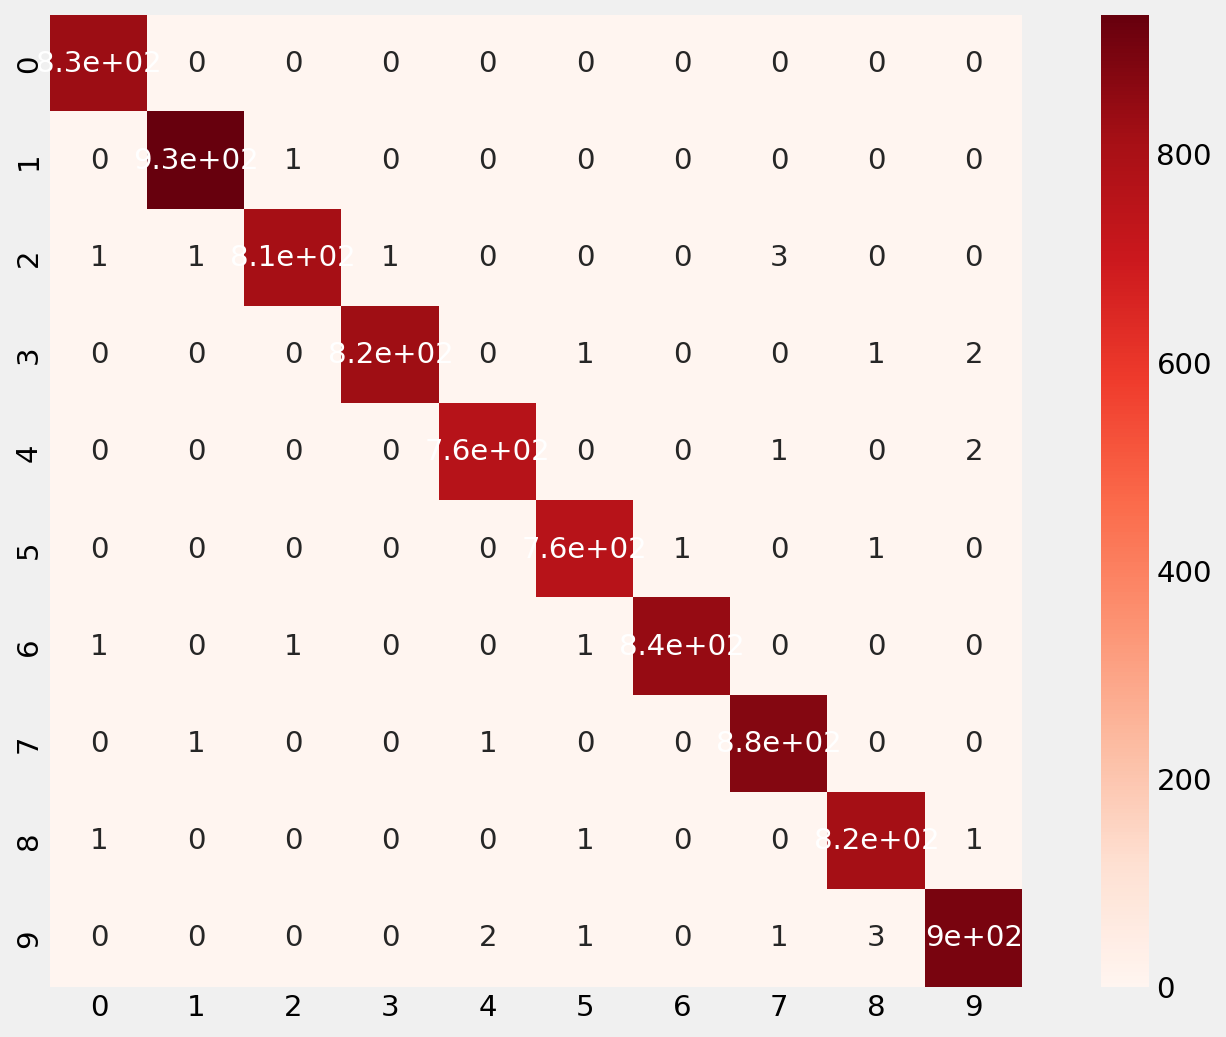

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


fig = plt.figure(dpi=150)
sns.heatmap(confusion_matrix(targs, preds.argmax(1)), cmap="Reds",
            square=True, annot=True);

In [16]:
test = pd.read_csv(Path("./test.csv"))

In [17]:
class TestDS(NumberDataset):
    def __getitem__(self, index):
        
        d = self.data.iloc[index, :].values.reshape(1, 28, 28)
        
        if self.trans:
            d = self.trans(tensor(d)/255)
        else:
            d = tensor(d)/255
        
        return d, tensor(0)



test_ds = TestDS(test)
test_dl = DataLoader(test_ds, bs=128, device=device)

In [18]:
preds, targ = learn.get_preds(dl=test_dl)

In [19]:
sub = pd.read_csv(Path("./sample_submission.csv"))
sub["Label"] = np.argmax(preds, axis=1)
sub.to_csv("submission.csv", index=False)